## Matrix of Outcomes

Matrix of educational outcomes by state is from [here](https://nces.ed.gov/ipeds/trendgenerator/app/build-table/4/210?cid=1&rid=6&ridv=1%7C2%7C4%7C5%7C6%7C8%7C9%7C10%7C11%7C12%7C13%7C15%7C16%7C17%7C18%7C19%7C20%7C21%7C22%7C23%7C24%7C25%7C26%7C27%7C28%7C29%7C30%7C31%7C32%7C33%7C34%7C35%7C36%7C37%7C38%7C39%7C40%7C41%7C42%7C44%7C45%7C46%7C47%7C48%7C49%7C50%7C51%7C53%7C54%7C55%7C56), recording the number of students awarded degrees/certificates at postsecondary institutions within the academic year (note: the school year 2012-2013 is coded as 2012)

In [2]:
import pandas as pd

# ------------------------------
# 1. Load CSV while skipping junk header rows
# ------------------------------
df_raw = pd.read_csv("cceducation.csv", skiprows=3)

# Make df name more specific
df_cc = df_raw.copy()

# ------------------------------
# 2. Clean numeric columns (remove commas)
# ------------------------------
df_cc["Public, 2-year"] = (
    df_cc["Public, 2-year"]
    .astype(str)
    .str.replace(",", "")
    .replace("N/A", None)
    .astype(float)
)

# ------------------------------
# 3. Convert completion years like "2012-13" to 2012
# ------------------------------
# Remove any rows where Completion Year is not a valid year like "2023-24"
df_cc = df_cc[df_cc["Completion Year"].str.match(r"^\d{4}")]

df_cc["Completion Year"] = (
    df_cc["Completion Year"]
    .astype(str)
    .str.slice(0, 4)
    .astype(int)
)

# ------------------------------
# 4. Keep only relevant columns
# ------------------------------
df_cc = df_cc[["State", "Completion Year", "Public, 2-year"]]

# ------------------------------
# 5. Filter for the years you want
# ------------------------------
valid_years = list(range(2010, 2020))
df_cc = df_cc[df_cc["Completion Year"].isin(valid_years)]

# ------------------------------
# 6. Create outcome matrix Y
#     rows = states
#     cols = years
# ------------------------------
Y = df_cc.pivot(index="State", columns="Completion Year", values="Public, 2-year")

# Sort columns for nice ordering
Y = Y[sorted(Y.columns)]

#change columns name
Y.columns.name = "Year"

# Remove rows with any missing data
Y = Y.dropna()

Y.head()


Year,2011,2012,2013,2014,2015,2016,2017,2018,2019
State,,,,,,,,,
Alabama,13590.0,12911.0,12387.0,13184.0,13488.0,14403.0,14568.0,17025.0,15942.0
Arizona,29383.0,28059.0,28831.0,29574.0,29255.0,28108.0,28658.0,28223.0,28709.0
Arkansas,12712.0,11981.0,14111.0,13052.0,12338.0,12250.0,11573.0,12365.0,12212.0
California,108842.0,119722.0,125970.0,133980.0,123445.0,124980.0,136183.0,152627.0,148563.0
Colorado,14338.0,15419.0,16643.0,17169.0,13945.0,13697.0,9245.0,4757.0,4370.0


## Matrix of Treatments

The following treatment matrix (using data from [here](https://sites.socsci.uci.edu/~dneumark/datasets.html)) has states as rows and year-months as columns, with 1s indicating treated periods (when state MW > federal minimum). The federal minimum wage last increased in 2009, so we will look at timepoints from 2010 onwards. We also remove states that begin 2010 above the federal minimum wage as no causal effect can be estimated.

In [3]:
import pandas as pd

# Read the minimum wage data
mw_data = pd.read_csv('MW_LW dataset updated through 2019 - 1-01-20 Update (1).csv')

# Convert Year, Quarter, Month to datetime for easier handling
mw_data['date'] = pd.to_datetime(mw_data['Year'].astype(str) + '-' +
                                  mw_data['Month'].astype(str),
                                  format='%Y-%m', errors='coerce')

# Create a year-month identifier
mw_data['year_month'] = mw_data['Year'].astype(str) + '-' + mw_data['Month'].astype(str).str.zfill(2)

# For treatment definition, we need to know the federal minimum wage
# Federal minimum has been $7.25 since July 2009
FEDERAL_MW = 7.25

# Identify if state MW is above federal (treated)
mw_data['above_federal'] = (mw_data['MW'] > FEDERAL_MW).astype(int)

# Filter to 2011 onwards
mw_post2010 = mw_data[mw_data['Year'] >= 2011].copy()

#change column name

mw_post2010 = mw_post2010.rename(columns={'State Name': 'state'})

# Create treatment indicator: state is treated starting from first month it raised MW above federal
treatment_status = []

for state in mw_post2010['state'].unique():
    state_data = mw_post2010[mw_post2010['state'] == state].sort_values('Year')

    # Find first instance where MW > federal after 2011
    first_treatment = state_data[state_data['above_federal'] == 1]

    if len(first_treatment) > 0:
        treatment_year = first_treatment.iloc[0]['Year']
        treatment_month = first_treatment.iloc[0]['Month']

        # Mark as treated from that point forward
        state_data['treated'] = 0
        state_data.loc[(state_data['Year'] > treatment_year) |
                       ((state_data['Year'] == treatment_year) &
                        (state_data['Month'] >= treatment_month)), 'treated'] = 1
    else:
        state_data['treated'] = 0

    treatment_status.append(state_data)

treatment_long = pd.concat(treatment_status, ignore_index=True)

# Create treatment matrix: rows = states, columns = year-months, values = treatment status
dfw = treatment_long.pivot_table(
    index='state',
    columns='year_month',
    values='treated',
    aggfunc='first'  # Take first value if duplicates
)

# Sort columns chronologically
dfw = dfw[sorted(dfw.columns)]



#  Extract only January columns
january_cols = [col for col in dfw.columns if col.endswith('-01')]
W = dfw[january_cols].copy()


#  Rename columns to just the year (remove '-01')
W = W.rename(columns={col: col[:4] for col in W.columns})
W.columns.name = "year"


# Save to CSV
#W.to_csv('mw_treatment_panel.csv')

W.head(10)



year,2011,2012,2013,2014,2015,2016,2017,2018,2019
state,,,,,,,,,
Alabama,0,0,0,0,0,0,0,0,0
Alaska,1,1,1,1,1,1,1,1,1
Arizona,1,1,1,1,1,1,1,1,1
Arkansas,0,0,0,0,1,1,1,1,1
California,1,1,1,1,1,1,1,1,1
Colorado,1,1,1,1,1,1,1,1,1
Connecticut,1,1,1,1,1,1,1,1,1
DC,1,1,1,1,1,1,1,1,1
Delaware,0,0,0,0,1,1,1,1,1


## Further Cleaning

In [4]:
import numpy as np

# Identify rows that are fully treated
rows_all_treated = np.all(W == 1, axis=1)

# Keep only rows that are not fully treated
W = W[~rows_all_treated.values]
W.head(10)

year,2011,2012,2013,2014,2015,2016,2017,2018,2019
state,,,,,,,,,
Alabama,0,0,0,0,0,0,0,0,0
Arkansas,0,0,0,0,1,1,1,1,1
Delaware,0,0,0,0,1,1,1,1,1
Florida,0,1,1,1,1,1,1,1,1
Georgia,0,0,0,0,0,0,0,0,0
Hawaii,0,0,0,0,1,1,1,1,1
Idaho,0,0,0,0,0,0,0,0,0
Indiana,0,0,0,0,0,0,0,0,0
Iowa,0,0,0,0,0,0,0,0,0


In [5]:
# keep only rows whose index is present in BOTH W and Y.

# 1. Find intersection of row indices
common_rows = W.index.intersection(Y.index)

# 2. Subset both matrices to ONLY those rows
W = W.loc[common_rows]
Y = Y.loc[common_rows]


In [6]:
# Convert to arrays for matrix completion
Y_matrix = Y.to_numpy()
W_matrix = W.to_numpy()

## Long-Format Dataset

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# ----------------------------------------------------
# 1. Rename index so melting doesn't create "index"
# ----------------------------------------------------
Y = Y.copy()
W = W.copy()

Y.index.name = "state"
W.index.name = "state"

# ----------------------------------------------------
# 2. LONG FORMAT
# ----------------------------------------------------
dfy_long = (
    Y
    .reset_index()
    .melt(id_vars="state", var_name="year", value_name="Y")
)

dfw_long = (
    W
    .reset_index()
    .melt(id_vars="state", var_name="year", value_name="D")
)

# Convert year safely (ignore anything not numeric)
dfy_long["year"] = pd.to_numeric(dfy_long["year"], errors="coerce")
dfw_long["year"] = pd.to_numeric(dfw_long["year"], errors="coerce")

dfy_long = dfy_long.dropna(subset=["year"])
dfw_long = dfw_long.dropna(subset=["year"])

dfy_long["year"] = dfy_long["year"].astype(int)
dfw_long["year"] = dfw_long["year"].astype(int)

# ----------------------------------------------------
# 3. MERGE outcome + treatment
# ----------------------------------------------------
df = dfy_long.merge(dfw_long, on=["state", "year"], how="inner")

# ----------------------------------------------------
# 4. First treated year
# ----------------------------------------------------
first_treat = (
    df.query("D == 1")
    .groupby("state")["year"]
    .min()
    .rename("first_treat_year")
)

df = df.merge(first_treat, on="state", how="left")

# ----------------------------------------------------
# 5. Event time
# ----------------------------------------------------
df["event_time"] = df["year"] - df["first_treat_year"]

# ----------------------------------------------------
# 6. Build event-time dummies (omit -1)
# ----------------------------------------------------
unique_event_times = df["event_time"].dropna().unique()

for k in unique_event_times:
    if k == -1:
        continue
    df[f"event_{int(k)}"] = (df["event_time"] == k).astype(int)


df.head()


,state,year,Y,D,first_treat_year,event_time,event_-4,event_-2,event_-3,event_0,event_1,event_2,event_3,event_4,event_5,event_6,event_7
0,Alabama,2011,13590.0,0,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0
1,Arkansas,2011,12712.0,0,2015.0,-4.0,1,0,0,0,0,0,0,0,0,0,0
2,Florida,2011,26902.0,0,2012.0,-1.0,0,0,0,0,0,0,0,0,0,0,0
3,Georgia,2011,33225.0,0,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0
4,Hawaii,2011,2853.0,0,2015.0,-4.0,1,0,0,0,0,0,0,0,0,0,0


## Comparing Cohort Characteristics and Visualizing State Outcomes

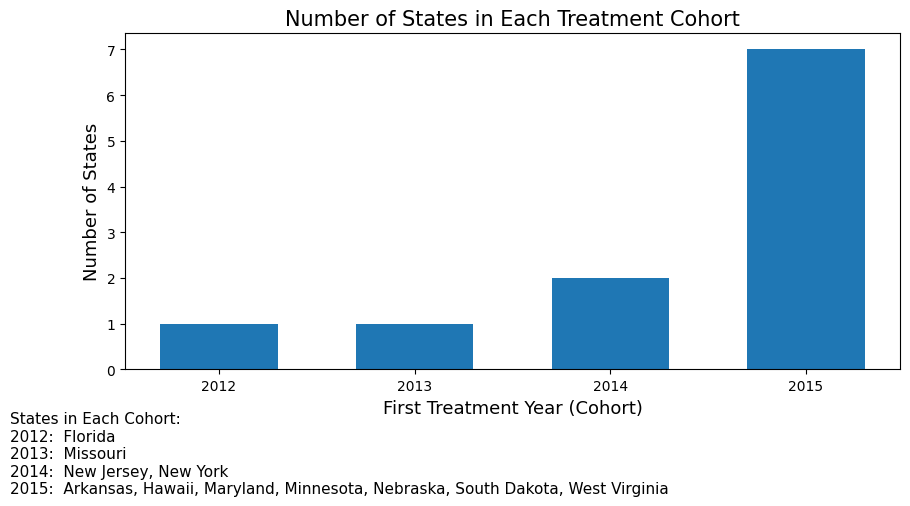

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# ---------------------------------
# 1. Count states per cohort
# ---------------------------------
cohort_counts = (
    df[["state", "first_treat_year"]]
    .drop_duplicates()
    .groupby("first_treat_year")
    .size()
)

# ---------------------------------
# 2. List states per cohort
# ---------------------------------
states_per_cohort = (
    df[["state", "first_treat_year"]]
    .drop_duplicates()
    .groupby("first_treat_year")["state"]
    .apply(list)
)

# ---------------------------------
# 3. Build clean text block
# ---------------------------------
state_text_lines = []
for yr in cohort_counts.index:
    state_list = ", ".join(states_per_cohort[yr])
    state_text_lines.append(f"{int(yr)}:  {state_list}")
state_text = "\n".join(state_text_lines)

# ---------------------------------
# 4. Plot
# ---------------------------------
fig, ax = plt.subplots(figsize=(10, 6))

# Use *exact cohort years* as x positions
x_vals = cohort_counts.index.astype(int)
y_vals = cohort_counts.values

ax.bar(x_vals, y_vals, width=0.6)

# ----- Fix ticks so .5 never appears -----
ax.set_xticks(x_vals)
ax.set_xticklabels(x_vals)

ax.set_xlabel("First Treatment Year (Cohort)", fontsize=13)
ax.set_ylabel("Number of States", fontsize=13)
ax.set_title("Number of States in Each Treatment Cohort", fontsize=15)

# ---------------------------------
# 5. Add the cohort/state text block below
# ---------------------------------
plt.gcf().text(
    0.01, 0.25,
    "States in Each Cohort:\n" + state_text,
    fontsize=11,
    va="top",
    ha="left"
)

plt.subplots_adjust(bottom=0.32)

plt.show()

# ---------------------------------
# 6. Save figure cleanly
# ---------------------------------
fig.savefig("cohort_states_plot.png", dpi=300, bbox_inches="tight")


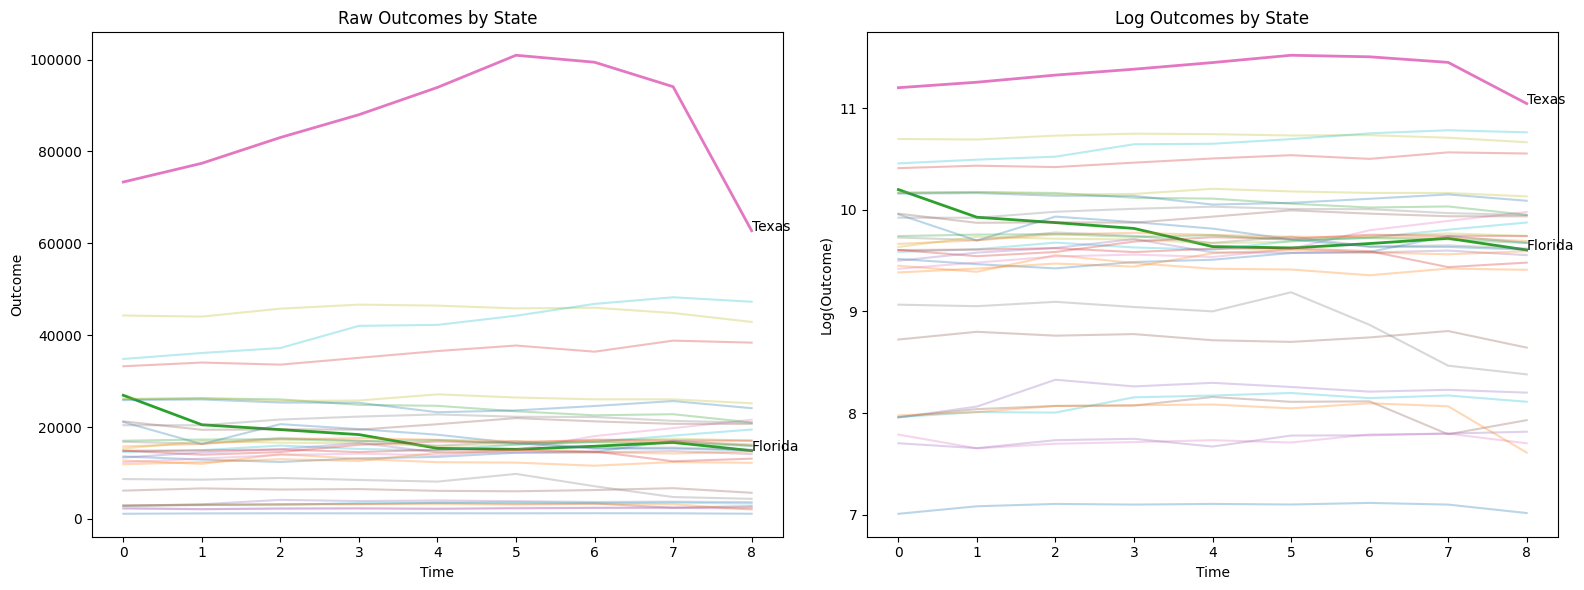

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Extract state labels from df
state_labels = df['state'].unique().tolist()  # ensure order matches Y_matrix rows

# Find indices for Texas and Florida
highlight_states = ['Texas', 'Florida']
highlight_indices = [i for i, state in enumerate(state_labels) if state in highlight_states]

# Create figure with 1 row, 2 columns
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Left plot: Raw outcomes
for i in range(Y_matrix.shape[0]):
    if i in highlight_indices:
        axes[0].plot(Y_matrix[i, :], label=state_labels[i], linewidth=2)
        # Annotate the last point with the state name
        axes[0].text(Y_matrix.shape[1]-1, Y_matrix[i, -1], state_labels[i])
    else:
        axes[0].plot(Y_matrix[i, :], alpha=0.3)
axes[0].set_title('Raw Outcomes by State')
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Outcome')

# Right plot: Log outcomes
for i in range(Y_matrix.shape[0]):
    if i in highlight_indices:
        axes[1].plot(np.log(Y_matrix[i, :]), label=state_labels[i], linewidth=2)
        axes[1].text(Y_matrix.shape[1]-1, np.log(Y_matrix[i, -1]), state_labels[i])
    else:
        axes[1].plot(np.log(Y_matrix[i, :]), alpha=0.3)
axes[1].set_title('Log Outcomes by State')
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Log(Outcome)')

plt.tight_layout()

fig.savefig("raw_and_log_outcomes.png", dpi=300, bbox_inches="tight")

plt.show()


## Take Log of Outcomes and Exporting df for C-S DiD

In [10]:
Y_matrix = np.log(Y_matrix)

In [11]:
df['Y'] = np.log(df['Y'])

In [12]:
# Export to CSV for Callaway–Sant’Anna in R
df.to_csv("did_df_educ.csv")


## TWFE DiD

In [13]:
!pip install linearmodels

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.3/117.3 kB 7.8 MB/s eta 0:00:00


In [14]:
# TWFE DiD regression
# ------------------------------
from linearmodels.panel import PanelOLS

# Set up the panel data structure
df_panel = df.set_index(['state', 'year'])

# TWFE DiD regression
formula_twfe = "Y ~ D + EntityEffects + TimeEffects"

mod_twfe = PanelOLS.from_formula(formula_twfe, data=df_panel)
res_twfe = mod_twfe.fit(cov_type='clustered', cluster_entity=True)
print(res_twfe)

                          PanelOLS Estimation Summary                           
Dep. Variable:                      Y   R-squared:                        0.0037
Estimator:                   PanelOLS   R-squared (Between):             -0.0011
No. Observations:                 288   R-squared (Within):              -0.0038
Date:                Thu, Dec 04 2025   R-squared (Overall):             -0.0011
Time:                        06:37:16   Log-likelihood                    267.03
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      0.9191
Entities:                          32   P-value                           0.3387
Avg Obs:                       9.0000   Distribution:                   F(1,247)
Min Obs:                       9.0000                                           
Max Obs:                       9.0000   F-statistic (robust):             0.4374
                            

## MC

In [15]:
!pip install lightweight-mcnnm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 26.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 MB 8.9 MB/s eta 0:00:00
  Attempting uninstall: jaxlib
    Found existing installation: jaxlib 0.7.2
    Uninstalling jaxlib-0.7.2:
      Successfully uninstalled jaxlib-0.7.2
  Attempting uninstall: jax
    Found existing installation: jax 0.7.2
    Uninstalling jax-0.7.2:
      Successfully uninstalled jax-0.7.2


In [16]:
from mcnnm import estimate
import numpy as np

# --- 0. Creating unit and time labels
unit_labels = Y.index.tolist()
time_labels = Y.columns.tolist()


# --- 1. Run matrix completion using mcnnm
res = estimate(Y=Y_matrix,
               Mask=W_matrix,
               X=None,
               Z=None,
               V=None,
               use_unit_fe=True,
               use_time_fe=True,
               validation_method="cv",
               K=3,
               n_lambda=20)

# --- 2. Full counterfactual matrix (imputed outcomes if untreated)
Y_cf = res.Y_completed

# --- 3. Unit-by-time treatment effects
tau_it = np.where(W_matrix == 1, Y_matrix - Y_cf, np.nan)

# --- 4. Average post-treatment effect per unit
unit_att = np.nanmean(np.where(W_matrix == 1, tau_it, np.nan), axis=1)

# --- 5. Event-study style aggregation relative to adoption
max_lead = 3
max_lag = 7
num_units, num_periods = Y_matrix.shape
event_matrix = np.full((num_units, max_lead + 1 + max_lag), np.nan)

for i in range(num_units):
    treated_periods = np.where(W_matrix[i, :] == 1)[0]
    if len(treated_periods) > 0:
        adopt = treated_periods[0]
        for t in range(num_periods):
            rel = t - adopt
            if -max_lead <= rel <= max_lag:
                event_matrix[i, rel + max_lead] = tau_it[i, t]

# --- 6. Average treatment effect by relative period
event_avg = np.nanmean(event_matrix, axis=0)

# --- 7. Overall average ATT
tau_overall = res.tau
print(tau_overall)


/usr/local/lib/python3.12/dist-packages/jaxlib/plugin_support.py:71: RuntimeWarning: JAX plugin jax_cuda12_plugin version 0.7.2 is installed, but it is not compatible with the installed jaxlib version 0.6.2, so it will not be used.
  warnings.warn(


-0.08219675939258296


/tmp/ipython-input-3832691958.py:28: RuntimeWarning: Mean of empty slice
  unit_att = np.nanmean(np.where(W_matrix == 1, tau_it, np.nan), axis=1)
/tmp/ipython-input-3832691958.py:46: RuntimeWarning: Mean of empty slice
  event_avg = np.nanmean(event_matrix, axis=0)


### MC Results

Average post-treatment effect per unit:
              Unit  Unit_ATT
0          Alabama       NaN
1         Arkansas -0.076946
2          Florida -0.513933
3          Georgia       NaN
4           Hawaii  0.032511
5            Idaho       NaN
6          Indiana       NaN
7             Iowa       NaN
8           Kansas       NaN
9         Kentucky       NaN
10       Louisiana       NaN
11        Maryland -0.034645
12       Minnesota -0.133175
13     Mississippi       NaN
14        Missouri  0.001784
15        Nebraska -0.077603
16   New Hampshire       NaN
17      New Jersey  0.015481
18        New York -0.020070
19  North Carolina       NaN
20    North Dakota       NaN
21        Oklahoma       NaN
22    Pennsylvania       NaN
23  South Carolina       NaN
24    South Dakota  0.032797
25       Tennessee       NaN
26           Texas       NaN
27            Utah       NaN
28        Virginia       NaN
29   West Virginia  0.063124
30       Wisconsin       NaN
31         Wyoming       NaN

Un

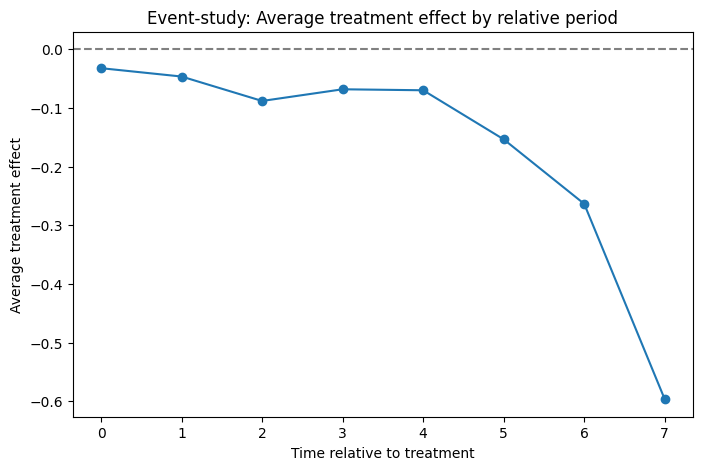

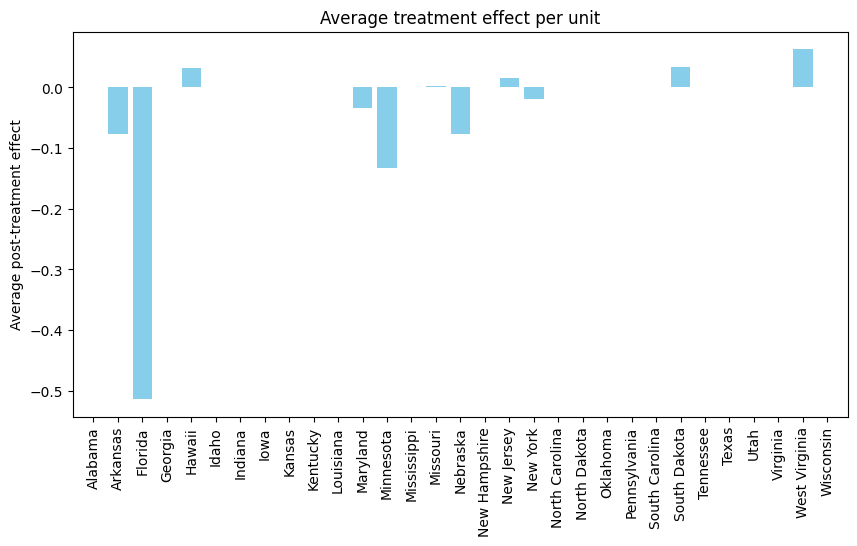

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# --- 1. Unit ATT per unit
unit_att_df = pd.DataFrame({
    'Unit': unit_labels,
    'Unit_ATT': unit_att
})
print("Average post-treatment effect per unit:")
print(unit_att_df)

# --- 2. Raw tau_it table
tau_it_df = pd.DataFrame(tau_it, index=unit_labels, columns=time_labels)
print("\nUnit × time treatment effects (tau_it):")
print(tau_it_df)

# --- 3. Event-study averages by relative period
relative_time = np.arange(-max_lead, max_lag + 1)
event_avg_df = pd.DataFrame({
    'Relative_Time': relative_time,
    'Event_Avg': event_avg
})
print("\nEvent-study average by relative period:")
print(event_avg_df)

# --- 4. Plot: Event-study
plt.figure(figsize=(8,5))
plt.plot(event_avg_df['Relative_Time'], event_avg_df['Event_Avg'], marker='o')
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel('Time relative to treatment')
plt.ylabel('Average treatment effect')
plt.title('Event-study: Average treatment effect by relative period')

# Save figure
plt.savefig("matrix_completion_event_study.png", dpi=300, bbox_inches="tight")

plt.show()


# --- 5. Plot: Unit ATT per unit
plt.figure(figsize=(10,5))
plt.bar(unit_labels, unit_att, color='skyblue')
plt.xticks(rotation=90)
plt.ylabel('Average post-treatment effect')
plt.title('Average treatment effect per unit')
plt.show()


In [18]:
# ============================================================
# Placebo-based Validation / Permutation Test
# ============================================================

import numpy as np
import jax.numpy as jnp

# Convert to NumPy for indexing logic
W_np = np.array(W_matrix)
Y_np = np.array(Y_matrix)

# Identify treated and control units
treated_units = np.where(W_np.sum(axis=1) > 0)[0]
control_units  = np.where(W_np.sum(axis=1) == 0)[0]

# Store each treated unit's timing pattern (their treatment path)
treat_patterns = {i: W_np[i, :].copy() for i in treated_units}

# Observed effect
tau_obs = float(res.tau)

tau_placebos = []

# Loop: assign each treated pattern to each control unit
for t_unit in treated_units:
    pattern = treat_patterns[t_unit]

    for c in control_units:
        # Create placebo W
        W_pl = np.zeros_like(W_np)
        W_pl[c, :] = pattern

        # Convert to JAX
        W_pl_jnp = jnp.array(W_pl, dtype=jnp.int32)

        # Re-run matrix completion with placebo
        res_pl = estimate(
            Y=Y_matrix,
            Mask=W_pl_jnp,
            X=None,
            Z=None,
            V=None,
            use_unit_fe=True,
            use_time_fe=True,
            validation_method="cv",
            K=3,
            n_lambda=20
        )

        tau_placebos.append(float(res_pl.tau))

# Convert to array
tau_placebos = np.array(tau_placebos)

# p-value
p_val = np.mean(np.abs(tau_placebos) >= abs(tau_obs))

print("------------------------------------------------------")
print("Placebo taus:", tau_placebos)
print(f"Observed tau: {tau_obs:.4f}")
print(f"P-value:      {p_val:.4f}")
print(f"Mean placebo tau: {tau_placebos.mean():.4f}")
print(f"SD placebo tau:   {tau_placebos.std():.4f}")
print("------------------------------------------------------")


------------------------------------------------------
Placebo taus: [ 0.15437818  0.08753415 -0.04314722  0.23902424 -0.0775657   0.00553879
  0.11167563 -0.18234106  0.11409203  0.05340631  0.15739919 -0.00832052
  0.14720495 -0.03489864 -0.05079443  0.08176074  0.06090911 -0.28409193
  0.00926295 -0.05425192 -0.07858557  0.01259776  0.06044434  0.04823549
  0.23414525 -0.06600826  0.05984274  0.09053939 -0.25348438  0.055074
 -0.09558892  0.18301609  0.0545384   0.12183172 -0.04585458 -0.06489058
 -0.0702109   0.14083772 -0.21583471 -0.03365199 -0.07712904  0.00212226
  0.15437818  0.08753415 -0.04314722  0.23902424 -0.0775657   0.00553879
  0.11167563 -0.18234106  0.11409203  0.05340631  0.15739919 -0.00832052
  0.14720495 -0.03489864 -0.05079443  0.08176074  0.06090911 -0.28409193
  0.00926295 -0.05425192 -0.07858557  0.15437818  0.08753415 -0.04314722
  0.23902424 -0.0775657   0.00553879  0.11167563 -0.18234106  0.11409203
  0.05340631  0.15739919 -0.00832052  0.14720495 -0.03489